In [2]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import matplotlib as mpl

# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18


In [3]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)


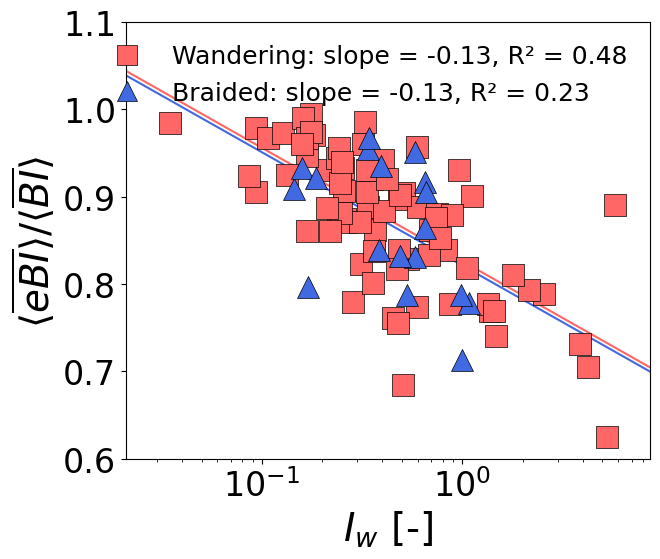

In [78]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['Iw'].min() * 0.6, df['Iw'].max() * 1.5)

# Define markers and colors for groups
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes first
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² information for the legend
legend_info = {}

# Loop through each group to compute and plot the regression lines.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Iw']
    y_data = subset['eBI_BI_ratio_site']
    
    # Ensure x_data are positive for log transformation
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using mode "log-x" (i.e. y = m*log(x) + b)
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate a set of x-values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² info for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Now plot the data points (and error bars if desired)
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Iw']
    y_data = subset['eBI_BI_ratio_site']
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=0.6,top=1.1)  # Adjust as needed

# Set labels and tick parameters
ax.set_xlabel(r'${I_{w}}$ [-]')  # Display fraction as LaTeX
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle/\langle\overline{\mathit{BI}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_eBI_BI_Iw_time.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


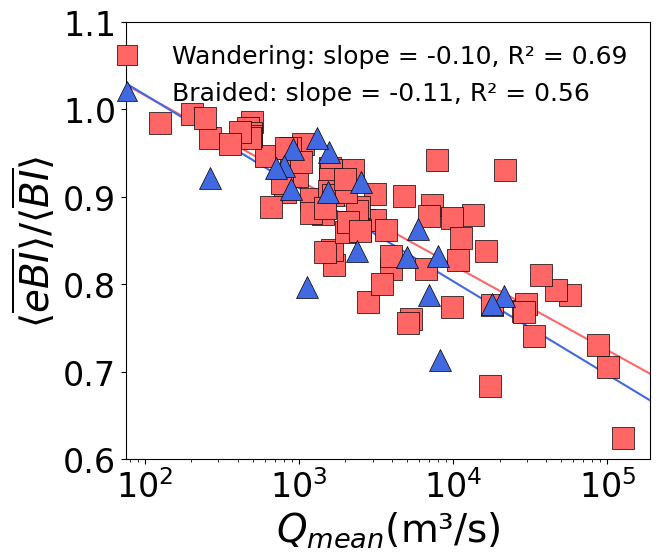

In [79]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['Qm'].min() * 0.6, df['Qm'].max() * 1.5)  # Add 10% padding

# Define markers and colors for groups
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes first
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² information for the legend
legend_info = {}

# Loop through each group to compute and plot the regression lines.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qm']
    y_data = subset['eBI_BI_ratio_site']
    
    # Ensure x_data are positive for log transformation
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using mode "log-x" (i.e. y = m*log(x) + b)
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate a set of x-values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² info for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Now plot the data points (and error bars if desired)
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Qm']
    y_data = subset['eBI_BI_ratio_site']
    
    # Uncomment the next line to include error bars:
    # ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=0.6, top=1.1)  # Adjust as needed

# Set labels and tick parameters
ax.set_xlabel(r'${Q_{mean}}$(m³/s)')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle/\langle\overline{\mathit{BI}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements,loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_eBI_BI_q.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


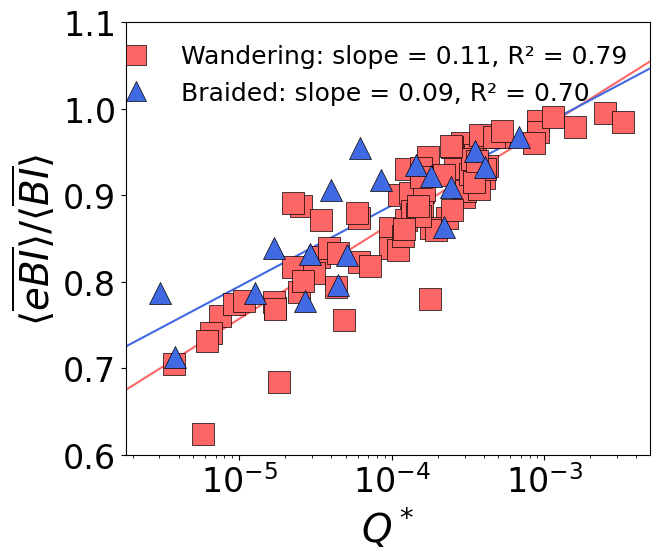

In [85]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['dim_Q'].min() * 0.6, df['dim_Q'].max() * 1.5)

# Define markers and colors for groups
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes first
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² information for the legend
legend_info = {}

# Loop through each group to compute and plot the regression lines.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['eBI_BI_ratio_site']
    
    # Ensure x_data are positive for log transformation
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using mode "log-x" (i.e. y = m*log(x) + b)
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")
    
    # Generate a set of x-values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² info for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Now plot the data points (and error bars if desired)
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['dim_Q']
    y_data = subset['eBI_BI_ratio_site']
    
    # Uncomment the next line to include error bars:
    # ax.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=0.6,top=1.1)  # Adjust as needed

# Set labels and tick parameters
ax.set_xlabel(r'${Q^*}$')  # X-axis labeled as Q*
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle/\langle\overline{\mathit{BI}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle ='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle ='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_eBI_BI_q_star.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

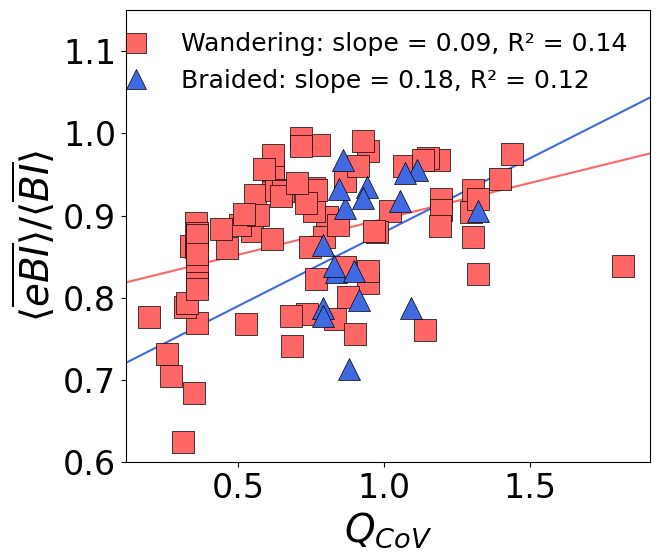

In [6]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['cov_discharge_site'].min() * 0.6, df['cov_discharge_site'].max() * 1.05)

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² info for the legend
legend_info = {}

# Loop through each group to compute and plot the regression line.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_discharge_site']
    y_data = subset['eBI_BI_ratio_site']
    
    # Ensure x_data are positive (needed for log transformation)
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using the unified function with mode "log-x"
    slope, intercept, predict = fit_regression(x_data, y_data, mode="linear")
    
    # Generate regression line values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² information for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['cov_discharge_site']
    y_data = subset['eBI_BI_ratio_site']
    
    # Optionally, uncomment the errorbar line if desired:
    # ax.errorbar(x_data, y_data, yerr=error_data, fmt='none',
    #             ecolor='black', elinewidth=2, capsize=5, zorder=1)
    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=1, zorder=2, linewidths=0.5)

# Set x-axis to log scale and adjust limits
#ax.set_xscale('log')
ax.set_xlim(*x_range)
ax.set_ylim(bottom=0.6, top=1.15)

# Set labels and tick parameters
ax.set_xlabel(r'${Q_{CoV}}$')
ax.set_ylabel(r'$\langle\overline{\mathit{eBI}}\rangle/\langle\overline{\mathit{BI}}\rangle$')
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\5_eBI_cov_q.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

Slope: -0.0547, Intercept: 1.3515, R-squared: 0.4273
Slope: -0.0055, Intercept: 0.9231, R-squared: 0.0040


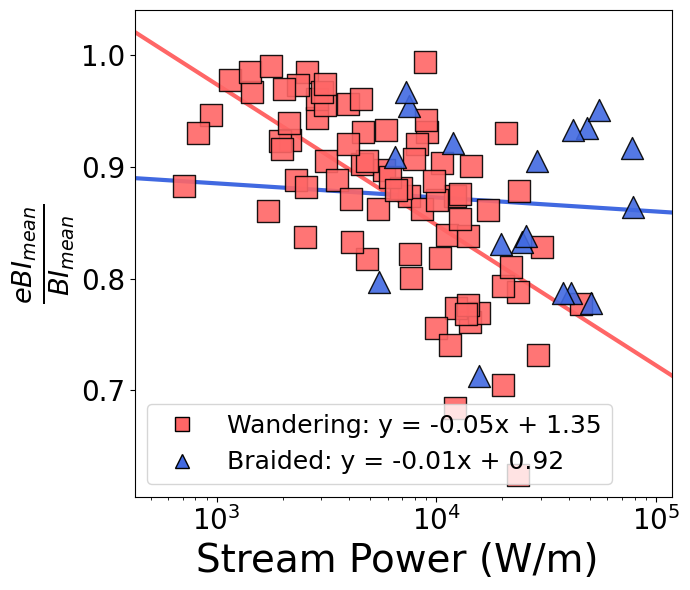

In [ ]:
# Dynamically calculate x_range based on data
x_range = (df['Stream Power (W/m) '].min() * 0.6, df['Stream Power (W/m) '].max() * 1.5)  # Add 10% padding

def fit_regression(x_data, y_data, x_range):
    # Filter valid values (positive, non-zero x_data)
    valid_mask = (x_data > 0) & ~x_data.isnull() & ~y_data.isnull()
    x_data = x_data[valid_mask]
    y_data = y_data[valid_mask]
    
    if len(x_data) < 2:  # Ensure enough data points for regression
        print("Not enough valid data points for regression.")
        return None, None, float('nan'), float('nan')
    
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R-squared: {r_squared:.4f}")  # Print results
    
    return np.exp(line_x), line_y, slope, intercept


# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 6))

# Define markers and colors
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Variables to store regression line equations for legend
legend_labels = {}
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Stream Power (W/m) ']
    y_data = subset['eBI_BI_ratio_site']
    line_x, line_y, slope, intercept = fit_regression(x_data, y_data, x_range)
    
    # Plot regression line
    ax.plot(line_x, line_y, color=colors[group], lw=3)
    
    # Store regression equation for legend
    legend_labels[group] = f"{slope:.2f}x + {intercept:.2f}"

# Plot data points with error bars
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['Stream Power (W/m) ']
    y_data = subset['eBI_BI_ratio_site']

    ax.scatter(x_data, y_data, label=group, marker=markers[group], c=colors[group], edgecolors='black', 
               s=250, alpha=0.9, zorder=2)

# Set log scale for x-axis
ax.set_xscale('log')
#ax.set_ylim(bottom=0, top=8.5)
ax.set_xlim(*x_range)

# Set labels and ticks
ax.set_xlabel(r'Stream Power (W/m) ', fontsize=28)  # Display fraction as LaTeX
ax.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with regression equations
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: y = {legend_labels['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: y = {legend_labels['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=18, loc='lower left')

# Tight layout and save figure
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_BI_slope.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

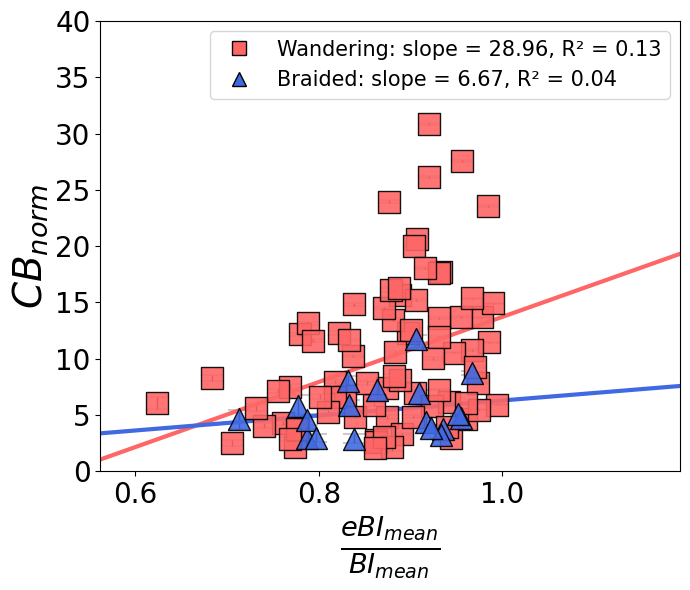

In [40]:
# Dynamically calculate x_range based on data (with padding)
x_range = (df['eBI_BI_ratio_site'].min() * 0.9, df['eBI_BI_ratio_site'].max() * 1.2)

# Define markers and colors for groups
markers = {'Wandering': 's', 'B': '^'}  # Combined HSW and LSW symbols
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

# Create the figure and axes first
fig, ax = plt.subplots(figsize=(7, 6))

# Dictionary to store slope and R² information for the legend
legend_info = {}

# Loop through each group to compute and plot the regression lines.
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['eBI_BI_ratio_site']
    y_data = subset['CB/Aw']
    
    # Ensure x_data are positive for log transformation
    if any(x_data <= 0):
        raise ValueError(f"Group {group} contains non-positive x values, cannot use log transformation.")
    
    # Fit regression using mode "log-x" (i.e. y = m*log(x) + b)
    slope, intercept, predict = fit_regression(x_data, y_data, mode="linear")
    
    # Generate a set of x-values over the full x_range
    x_line = np.linspace(x_range[0], x_range[1], 300)
    y_line = predict(x_line)
    
    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=3)
    
    # Compute R² on the original data
    y_pred = predict(x_data)
    ss_res = ((y_data - y_pred) ** 2).sum()
    ss_tot = ((y_data - y_data.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    
    # Store slope and R² info for the legend
    legend_info[group] = f"slope = {slope:.2f}, R² = {r2:.2f}"

# Now plot the data points (and error bars if desired)
for group in ['Wandering', 'B']:
    subset = df[df['Group'] == group]
    x_data = subset['eBI_BI_ratio_site']
    y_data = subset['CB/Aw']
    n = len(subset)
    y_error = subset['std_bi_site'] / np.sqrt(n)
    
    # Plot error bars.
    ax.errorbar(x_data, y_data, yerr=y_error, fmt='none', ecolor='black',
                capsize=8, alpha=1, zorder=1,capthick=0.3, elinewidth=1)

    
    ax.scatter(x_data, y_data, label=group, marker=markers[group],
               c=colors[group], edgecolors='black', s=250, alpha=0.9, zorder=2)

# Set x-axis to log scale and adjust limits
#ax.set_xscale('log')
ax.set_xlim(*x_range)
#ax.set_yscale('log')

ax.set_ylim(0, 40)  # Adjust as needed

# Set labels and tick parameters
ax.set_xlabel(r'$\frac{eBI_{mean}}{BI_{mean}}$', fontsize=28)
ax.set_ylabel(r'${CB_{norm}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Create a legend with slope and R² information
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label=f"Wandering: {legend_info['Wandering']}",
           markerfacecolor=colors['Wandering'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label=f"Braided: {legend_info['B']}",
           markerfacecolor=colors['B'], markersize=10, markeredgecolor='black')
]
ax.legend(handles=legend_elements, fontsize=15, loc='upper right')

plt.tight_layout()
plt.show()